<a href="https://colab.research.google.com/github/N3wBaz/ml-intro/blob/main/6_feature_engineering_selection/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA

from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.datasets import make_classification, load_wine, load_breast_cancer, load_diabetes, load_digits


from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVR

In [2]:
plt.style.use('seaborn-darkgrid')

In [3]:
def plot_scatter(x, y, auto_scaled=True, title=None, clusters=None):
    plt.figure(figsize=(6, 6))
    plt.scatter(x, y, c=clusters, cmap='bwr')
    
    if not auto_scaled:
        plt.axis('square')
    
    plt.grid(True)
    plt.title(title)
    
    plt.show()
    
def return_X_y(data, target_column):
    return data.drop(target_column, axis=1), data[target_column]

In [4]:
wine_sklearn = load_wine(as_frame=True)
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

# Homework

## Exercise  1 - Scaling (2 points)

Perform standardization for wine dataset (`wine_data`) using only basic python, numpy and pandas (without using `StandardScaler` and sklearn at all). Implementation of function (or class) that can get dataset as input and return standardized dataset as output is preferrable, but not necessary.

Compare you results (output) with `StandardScaler`.

**NOTE:**

- 1 point for functional version, 2 points for implementing scaling as sklearn pipeline compartible class. 
- Maximum for the exercise is 2 points.


### Simple version (1 point)

In [5]:
def scale(X):
    temp_data = pd.DataFrame()    
    for column in X.columns:
        temp_data[column] = (X[column] - X[column].mean()) / X[column].std(ddof=0)
    return temp_data


In [6]:
assert np.allclose(np.array(scale(wine_data)), StandardScaler().fit_transform(wine_data))

### Pipeline Version (2 points)

In [7]:
# 2 points
from sklearn.base import BaseEstimator, TransformerMixin
class CustomScaler(BaseEstimator, TransformerMixin):
    def __init__(self, copy=True, with_mean=True, with_std=True):
        self.copy = copy
        self.with_mean=True
        self.with_std=True

    def fit(self, X, y=None):
        self.mean = []
        self.std = []

        for column in X.columns:
            if self.with_mean:
                self.mean.append(X[column].mean())
            else:
                self.mean.append(0)
            if self.with_mean:
                self.std.append(X[column].std(ddof=0))
            else:
                self.std.append(1)        
        return self

    def transform(self, X, y=None, copy=None):
        if copy is None:
            temp_data = X         
        else:
            temp_data = X.copy()
        accum = pd.DataFrame()
        for i, column in enumerate(X.columns):
            accum[column] = (temp_data[column] - self.mean[i]) / self.std[i]
        
        return accum


In [8]:
assert np.allclose(CustomScaler().fit_transform(wine_data), StandardScaler().fit_transform(wine_data))

**Вывод по пункту**

Написан класс CustomScaler который нормирует данные по такому же принципу как и StandardScaler. От значения признака отнимаем среднее значение и делим на дисперсию признака. Получаем признаки со средним равным нулю и дисперсией равной единице.

Результат применения полученого класса к wine_data сравнены с применением функции StandardScaler() путем использования функции np.allclose. Они одинаковы в пределах заданной погрешности.

## Exercise  2 - Visualization (3 points)

As noted earlier, standardization/normalization of data can be crucial for some distance-based ML methods.

Let�s generate some toy example of unnormalized data and visualize the importance of this process once more:

In [9]:
feature_0 = np.random.randn(1000) * 10   
feature_1 = np.concatenate([np.random.randn(500), np.random.randn(500) + 5])
data = np.column_stack([feature_0, feature_1])
data 

array([[ -8.78548394,   0.4140322 ],
       [-17.00962887,   0.1865139 ],
       [ -1.71896401,  -1.2309377 ],
       ...,
       [ 12.62598418,   5.68987795],
       [ -7.42834037,   4.64549458],
       [  4.6280748 ,   4.31369035]])

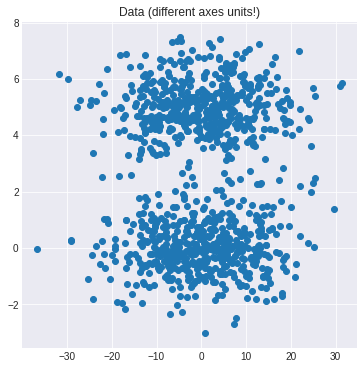

In [10]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=True, title='Data (different axes units!)')

**NOTE:** on the plot above axes are scaled differently and we can clearly see two potential *classes/clusters*. In fact `matplotlib` performed `autoscaling` (which is basically can be considered as `MinMaxScaling` of original data) just for better visualization purposes.

Let's turn this feature off and visualize the original data on the plot with equally scaled axes:

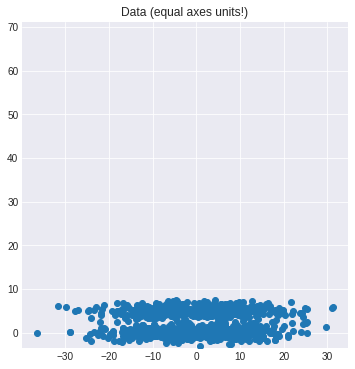

In [11]:
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Data (equal axes units!)')

This picture is clearly less interpretable, but much closer to "how distance-based algorithm see the original data": separability of data is hardly noticable only because the variation (std) of x-feature is much bigger in absolute numbers.

Perform `StandardScaling` and `MinMaxScaling` of original data; visualize results for each case (**use `plot_scatter` with `auto_scaled=False`**):

### MinMaxScaling (0.5 point)

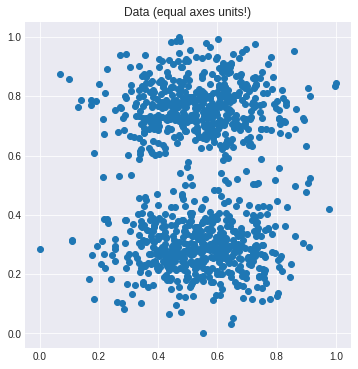

In [12]:
data_minmax = MinMaxScaler().fit_transform(data)
plot_scatter(data_minmax[:, 0], data_minmax[:, 1], auto_scaled=False , title='Data (equal axes units!)')


### StandardScaler (0.5 point)

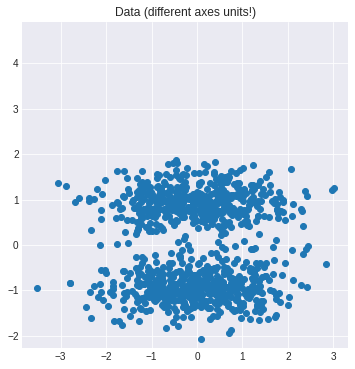

In [13]:
data_standard = StandardScaler().fit_transform(data)
plot_scatter(data_standard[:, 0], data_standard[:, 1], auto_scaled=False , title='Data (different axes units!)')


### (Bonus) K-means (2 points)

Illustrate the impact of scaling on basic distance-based clustering algorithm [K-means](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1) using `data` generated above.

**NOTE:** basically, you don't need understanding K-means algorithm here, you just need to:

1) run algorithm (with k=2, k - number of clusters/classes) on unscaled data    
2) run algorithm (with k=2) on scaled data    
3) plot results: highlight different clusters using different colors.

You can use this [question](https://stats.stackexchange.com/questions/89809/is-it-important-to-scale-data-before-clustering/89813) as a hint, but I recommend you to plot results using `plot_scatter` with `equal_scaled=True`: it might help you to intuitively understand the reasons of such scaling impact.


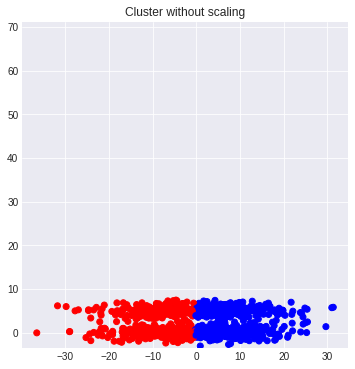

In [14]:
from sklearn.cluster import KMeans
Kmean = KMeans(n_clusters=2)
Kmean.fit(data)
Kmean.cluster_centers_
cluster = Kmean.predict(data)
plot_scatter(data[:, 0], data[:, 1], auto_scaled=False , title='Cluster without scaling', clusters=cluster)
# plt.scatter(data[:, 0], data[:, 1], c=cluster, cmap='bwr')

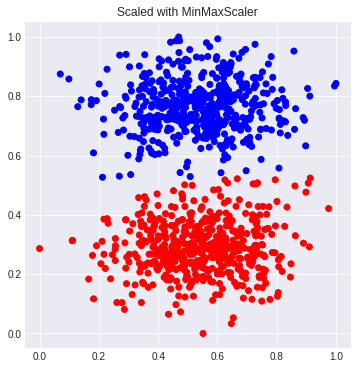

In [15]:
Kmean.fit(data_minmax)
Kmean.cluster_centers_
cluster = Kmean.predict(data_minmax)
plot_scatter(data_minmax[:, 0], data_minmax[:, 1], auto_scaled=False , title='Scaled with MinMaxScaler', clusters=cluster)

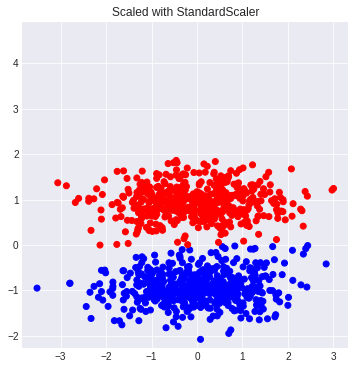

In [16]:
Kmean.fit(data_standard)
Kmean.cluster_centers_
cluster = Kmean.predict(data_standard)
plot_scatter(data_standard[:, 0], data_standard[:, 1], auto_scaled=False , title='Scaled with StandardScaler', clusters=cluster)

**Вывод по пункту**

Рассмотрены особенности применения разных функций стандартизации данных :
StandardScaler(), MinMaxScaler(). К 3-м группам данных (1. без стандартизации, 2. использован StandardScaler, 3 .использован MinMaxScaler) применен алгоритм кластеризации K-means, а также построенны графики полученных кластеров. Видно, что без нормализации данных K-means неправильно кластеризует данные, в то время как после нормализации кластеризация проходит правильно. 

Результат применения MinMaxScaler выглядит более наглядно, нежели StandardScaler. В документации sklearn написано, что это преобразование (MinMaxScaler) часто используется в качестве альтернативы масштабированию единичной дисперсии с нулевым средним значением.




## Exercise  3 - Preprocessing Pipeline (2 points)

In [17]:
wine_train, wine_val, wine_labels_train, wine_labels_val = train_test_split(wine_data, wine_labels, 
                                                                            test_size=0.3, random_state=42)

Train model (for example, `LogisticRegression(solver='liblinear', penalty='l1')` on raw `wine_train` data; then train same model after data scaling; then add feature selection (and train model again on scaled data). For each experiment all required preprocessing steps (if any) should be wrapped into sklearn pipeline.

Measure `accuracy` of all 3 approaches on `wine_val` dataset. Describe and explain results.

In [18]:
# Только логистическая регрессия
pipe_1 = Pipeline([
    ('clr', LogisticRegression(solver='liblinear', penalty='l1'))
])

pipe_1.fit(wine_train, wine_labels_train)
acc_1 = accuracy_score(pipe_1.predict(wine_val), wine_labels_val)


# Нормируем данные и применяем логистическую регрессию
pipe_2 = Pipeline([
    ('scaler',MinMaxScaler()),
    ('clr', LogisticRegression(solver='liblinear', penalty='l1'))
])

pipe_2.fit(wine_train, wine_labels_train)
acc_2 = accuracy_score(pipe_2.predict(wine_val), wine_labels_val)


# Нормируем данные, выбираем признаки SelectFromModel и применяем логистическую регрессию
rf = RandomForestClassifier(n_estimators=10, random_state=42)
pipe_3 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('select', SelectFromModel(estimator=rf)),
    ('clr', LogisticRegression(solver='liblinear', penalty='l1')),
])

pipe_3.fit(wine_train, wine_labels_train)
acc_3 = accuracy_score(pipe_3.predict(wine_val), wine_labels_val)


# Нормируем данные, выбираем признаки VarianceThreshold (статистический подход) и применяем логистическую регрессию
pipe_4 = Pipeline([
    ('select', VarianceThreshold(threshold=0.8)),
    ('scaler', MinMaxScaler()),
    ('clr', LogisticRegression(solver='liblinear', penalty='l1')),
])

pipe_4.fit(wine_train, wine_labels_train)
acc_4 = accuracy_score(pipe_4.predict(wine_val), wine_labels_val)


# Нормируем данные, выбираем признаки RFECV и применяем логистическую регрессию
estimator = SVR(kernel="linear")
pipe_5 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('select', RFECV(estimator, cv=3)),
    ('clr', LogisticRegression(solver='liblinear', penalty='l1')),
])

pipe_5.fit(wine_train, wine_labels_train)
acc_5 = accuracy_score(pipe_5.predict(wine_val), wine_labels_val)


# Нормируем данные, выбираем признаки SequentialFeatureSelector и применяем логистическую регрессию
knn = KNeighborsClassifier()
pipe_6 = Pipeline([
    ('scaler', MinMaxScaler()),
    ('select', SequentialFeatureSelector(knn, n_features_to_select=5)),
    ('clr', LogisticRegression(solver='liblinear', penalty='l1')),
])

pipe_6.fit(wine_train, wine_labels_train)
acc_6 = accuracy_score(pipe_6.predict(wine_val), wine_labels_val)

In [19]:
print('Только классификатор')
print(f"pipe_1 (val) : {acc_1}")
print(
    "pipe_1 (cross-val score): ",
    cross_val_score(pipe_1, wine_train, wine_labels_train, scoring="accuracy", cv=4).mean(),
)
print(f"Число коэффициентов : {pipe_1['clr'].coef_.shape[1]}")

print('\nНормированные данные и классификатор')
print(f"pipe_2 (val) : {acc_2}")
print(
    "pipe_2 (cross-val score): ",
    cross_val_score(pipe_2, wine_train, wine_labels_train, scoring="accuracy", cv=4).mean(),
)
print(f"Число коэффициентов : {pipe_2['clr'].coef_.shape[1]}")

print('\nНормированные данные, выбор признаков SelectFromModel + random forest  и классификатор')
print(f"pipe_3 (val): {acc_3}")
print(
    "pipe_3 (cross-val score): ",
    cross_val_score(pipe_3, wine_train, wine_labels_train, scoring="accuracy", cv=4).mean(),
)
print(f"Число коэффициентов : {pipe_3['clr'].coef_.shape[1]}")
arr = pipe_3['select'].get_feature_names_out().tolist()
features_name = wine_data.columns[[int(i[1:]) for i in arr]].tolist()
print(f"Название оставленных признаков: \n{features_name}")

print('\nНормированные данные, выбор признаков VarianceThreshold (стат. подход)  и классификатор')
print(f"pipe_4 (val) : {acc_4}")
print(
    "pipe_4 (cross-val score): ",
    cross_val_score(pipe_4, wine_train, wine_labels_train, scoring="accuracy", cv=4).mean(),
)
print(f"Число коэффициентов : {pipe_4['clr'].coef_.shape[1]}")
print(f"Название оставленных признаков : \n{pipe_4['select'].get_feature_names_out().tolist()}")

print('\nНормированные данные, выбор признаков RFECV(Рекурсивное исключение функций\n с перекрестной проверкой для выбора количества функций)  и классификатор')
print(f"pipe_5 (val) : {acc_5}")
print(
    "pipe_5 (cross-val score): ",
    cross_val_score(pipe_5, wine_train, wine_labels_train, scoring="accuracy", cv=4).mean(),
)
print(f"Число коэффициентов : {pipe_5['clr'].coef_.shape[1]}")
arr = pipe_5['select'].get_feature_names_out().tolist()
features_name = wine_data.columns[[int(i[1:]) for i in arr]].tolist()
print(f"Название оставленных признаков : \n{features_name}")

print('\nНормированные данные, выбор признаков SequentialFeatureSelector и классификатор')
print(f"pipe_6 (val) : {acc_6}")
print(
    "pipe_6 (cross-val score): ",
    cross_val_score(pipe_6, wine_train, wine_labels_train, scoring="accuracy", cv=4).mean(),
)
print(f"Число коэффициентов : {pipe_6['clr'].coef_.shape[1]}")
arr = pipe_6['select'].get_feature_names_out().tolist()
features_name = wine_data.columns[[int(i[1:]) for i in arr]].tolist()
print(f"Название оставленных признаков : \n{features_name}")



Только классификатор
pipe_1 (val) : 0.9814814814814815
pipe_1 (cross-val score):  0.9032258064516129
Число коэффициентов : 13

Нормированные данные и классификатор
pipe_2 (val) : 1.0
pipe_2 (cross-val score):  0.9596774193548387
Число коэффициентов : 13

Нормированные данные, выбор признаков SelectFromModel + random forest  и классификатор
pipe_3 (val): 1.0
pipe_3 (cross-val score):  0.9193548387096774
Число коэффициентов : 6
Название оставленных признаков: 
['alcohol', 'total_phenols', 'flavanoids', 'color_intensity', 'od280/od315_of_diluted_wines', 'proline']

Нормированные данные, выбор признаков VarianceThreshold (стат. подход)  и классификатор
pipe_4 (val) : 0.9629629629629629
pipe_4 (cross-val score):  0.9596774193548387
Число коэффициентов : 6
Название оставленных признаков : 
['malic_acid', 'alcalinity_of_ash', 'magnesium', 'flavanoids', 'color_intensity', 'proline']

Нормированные данные, выбор признаков RFECV(Рекурсивное исключение функций
 с перекрестной проверкой для выбора

**Вывод по пункту**

Как мы видим число признаков, которые выделяются как значимые варьируется от метода к методу, но некоторые признаки, такие как: alcohol, total_phenols, flavanoids, color_intensity, color_intensity выбираются почти всеми системами отбора признаков, следовательно эти признаки скорее всего вносят самый большой вклад в выбор класса вина. Также можно увидеть, что в результате отбора количество признаков уменьшается с 13 до 5 (в последнем случае), а точность полученной модели изменяется в небольших пределах. Почти все системы отбора признаков показывают лучшую или сопоставимую точность с моделью примененной к полным нормированным данным.

## Exercise 4 - manual PCA (5 points)
The task is to solve PCA as an optimization problem, without explicitly doing eigen value decomposition.
In the most general setting PCA is minimization of reconstruction error of a projection of given rank $q$

$$\min_{\mu, \lambda_1,\ldots, \lambda_n, \mathbf{V}_q} \sum_{i=1}^n ||x_i - \mu - \mathbf{V}_q \lambda_i||^2$$

With a number of steps that can be found here https://stats.stackexchange.com/a/10260 this task transforms to
 $$\max_{u_i} \sum_{i=1}^q u_i^T \mathbf{S} u_i$$
 where $\mathbf{S}$ is the sample covariance matrix (after standartization) and $u_1, \ldots, u_q$ are the $q$ are orthonormal columns in $\mathbf{V}_q$.
 Let us solve this optimization problem with `scipy.optimize` library.
 
 Additional 2 point are given for visualization of the results.

### PCA (3 points)

In [20]:
wine_data, wine_labels = wine_sklearn['data'], wine_sklearn['target']

Find a covariance matrix of standartized data and assing it to S.

In [21]:
wine = np.asarray(wine_data)
x = (wine - wine.mean(axis=0)) / wine.std(ddof=0, axis=0)
S = x.T @ x /( x.shape[0] - 1)

If your code is correct, the following assert should be Ok.

In [22]:
assert np.allclose(np.linalg.norm(S), 5.787241159764733)

In [23]:
from scipy.optimize import minimize

def objective(x):
    # your code: write objective of the problem (don't forget that scipy does min while we need max)

    # return -x.T @ S @ x
    return  -x[:, np.newaxis].T @ S @ x

def norm_constraint(x):
    # your code: constaraint norm of x to be 1, function should return 0 if constraint holds
    norm = np.linalg.norm(x)
    return 1 - norm

con1 = {'type': 'eq', 'fun': norm_constraint}

x0 = np.zeros(S.shape[0])

sol = minimize(objective, 
               x0, 
               constraints = [con1]
              )
x0 = sol.x

Hurray! We have first vector! Let's do another one.

In [24]:
def orthogonality_constraint(x):
    # your code: x should be orthogonal to x0, function should return 0 if constraint holds
    return (x[:,np.newaxis].T @ x0)

    # return np.dot(x, x0)

con2 = {'type': 'eq', 'fun': orthogonality_constraint}

# x1 = x0 = np.ones(S.shape[0])# your code: initial vector to start optimization
x1 = np.ones(S.shape[0])

sol = minimize(objective, 
               x1, 
               constraints = [con2, con1]
              )

x1 = sol.x

If your solution is correct, the following asserts should be Ok.

In [25]:
assert np.allclose(x0@S@x0, 4.732436977583595)
assert np.allclose(x1@S@x1, 2.5110809296451233)

### Visualization (2 points)

Visualize the points after applying custom dimension reduction with 2 components.

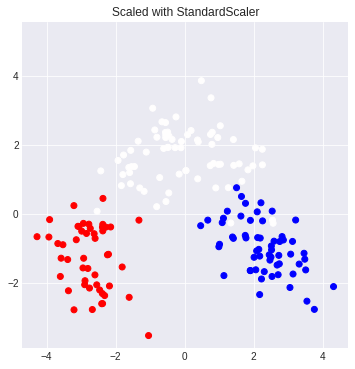

In [26]:
# print(type)
Xnew = np.dot(x0, x.T)
Ynew = np.dot(-x1, x.T)
# print(Xnew)
# print(Ynew)
plot_scatter(Xnew, Ynew, auto_scaled=False , title='Scaled with StandardScaler',  clusters=wine_labels)

**Вывод по пункту**

Реализован метод главных компонент. Посчитана матрица ковариации, а также собственные вектора, вычисленны проекции наших данных на полученные оси. По вычесленным данным построен график. На графике хорошо видно, что наши данные деляться на 3 хорошо разделимых класса.

Метод главных компонент применяется для понижения размерности данных с сохранением максимальног количества информации в них. Используется для облегчения вычислений при моделировании сложных систем, возможности отображения многомерных данных на 2-х или 3-х мерных графиках и т.п.

## Exercise 5 - Boruta (3 points)

Let us classify handwritten digits 0, 1 and 2. 
To make task not so easy the images are binarized (no shadows of gray present) as it happens with xerocopied documents.

Let us also find out to which parts of an image there's no need to look in order to clasify three digits of interest.

In [27]:
X, y = load_digits(n_class=3, return_X_y=True, as_frame=True)
X = (X>10).astype(int)

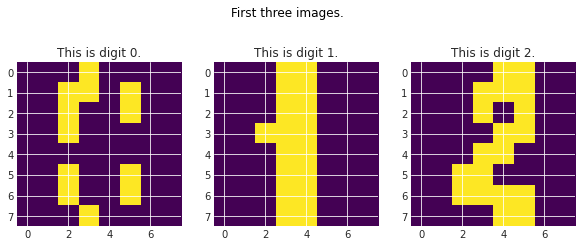

In [28]:
f, ax = plt.subplots(1,3,figsize=(10,4))
plt.style.use('default')
for i in range(3):
    ax[i].imshow(X.iloc[i].values.reshape(8,8))
    ax[i].set_title(f"This is digit {y[i]}.")
plt.suptitle("First three images.")
plt.show()

Split data into train and test, let test size be 30% of the dataset and fix random state to 42:

In [29]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
assert y_val.shape[0] == 162
assert y_val.sum() == 169

Fit a RandomForestClassifier with max_depth=13 and evaluate it's performance:

In [31]:
clf = RandomForestClassifier(max_depth=13, random_state=42)

clf.fit(X_train, y_train)

acc = accuracy_score(clf.predict(X_val), y_val)
print(acc)

0.9938271604938271


In [32]:
assert acc > 0.98

In [33]:
X_train.shape

(375, 64)

Now we will use Boruta to find redundand pixels. If the package is not installed in your system, uncomment and run the following cell.

In [34]:
! pip install boruta -q

In [35]:
from boruta import BorutaPy

feat_selector = BorutaPy(RandomForestClassifier(max_depth=13), 
                         n_estimators='auto', 
                         verbose=0, 
                         max_iter=100,
                         random_state=42)

feat_selector.fit(np.asarray(X_train), np.asarray(y_train))
# your code here: do run the boruta

BorutaPy(estimator=RandomForestClassifier(max_depth=13, n_estimators=62,
                                          random_state=RandomState(MT19937) at 0x7FA728E1C380),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FA728E1C380)

In [36]:
print('Список оставленных признаков')
pd.DataFrame(X_train.columns)[feat_selector.support_].values.reshape(1,-1).reshape(-1)


Список оставленных признаков


array(['pixel_0_2', 'pixel_0_3', 'pixel_0_4', 'pixel_0_5', 'pixel_1_2',
       'pixel_1_5', 'pixel_2_2', 'pixel_2_3', 'pixel_2_4', 'pixel_2_5',
       'pixel_3_2', 'pixel_3_3', 'pixel_3_4', 'pixel_3_5', 'pixel_4_2',
       'pixel_4_3', 'pixel_4_4', 'pixel_4_5', 'pixel_5_2', 'pixel_5_3',
       'pixel_5_4', 'pixel_5_5', 'pixel_6_2', 'pixel_6_3', 'pixel_6_4',
       'pixel_6_5', 'pixel_6_6', 'pixel_7_2', 'pixel_7_3', 'pixel_7_5',
       'pixel_7_6'], dtype=object)

Let us print redundant pixels as a mask. Does the result looks similar to mine (or to Among us chracters)? 

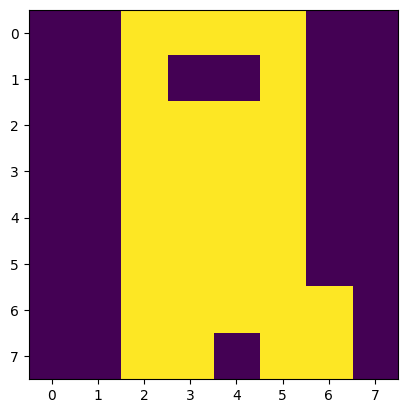

In [37]:
mask = np.array(feat_selector.support_).reshape(8,8)
plt.imshow(mask);

At the end let us redo  classification but only with selected features

In [38]:
clf = RandomForestClassifier(max_depth=13, random_state=42,n_estimators=1000)
X_train_boruto = feat_selector.transform(np.asarray(X_train))
X_val_boruto = feat_selector.transform(np.asarray(X_val))

clf.fit(X_train_boruto, y_train)
print("Точность на тренировочном датасете : ")
acc = accuracy_score(clf.predict(X_train_boruto), y_train)
print(acc)
print("Точность на валидационном датасете : ")
acc = accuracy_score(clf.predict(X_val_boruto), y_val)
print(acc)


Точность на тренировочном датасете : 
1.0
Точность на валидационном датасете : 
0.9938271604938271


In [39]:
assert acc > 0.99

**Вывод по пункту**

Применен метод отбора признаков Boruta, который основан на следующих шагах:


1.   Создаются "теневые" признаки путем копирования оригинальных.
2.   "Теневые" признаки перемешиваются для удаления корреляций с ответом.
3.   Запускается классификатор random forest и вычисляется cтандартизированная оценка (z-score)
4.   Среди "теневых" признаков находится максимальный z-score (MZSA), затем засчитывается каждое превышение z-score оригинальных признаков. 
5.   Если важность признака неопределена, выполняется тест на равенство MZSA.
6.   Все признаки у  которых z-score ниже MZSA считать "неважными".
7.   Признаки у которых z-score выше чем MZSA, считаются "важными".
8.   Все "неважные" признаки удаляются.
9.   Процедура повторяется до тех пор, пока всем атрибутам не будет присвоена важность или алгоритм не достигнет ранее установленного предела.

Алгоритм удаляет признаки, которые являются шумомовыми по отношению к целевой переменной, оставляя самые значимые.

**Общий вывод:**


1.   Написан и опробован класс CustomScaler, а так же произведено сравнение результатов со своим аналогом по функционалу StandardScaler.
2.   Проверено влияние разных функций нормирующих данные на качество кластеризации данных, построены графики.
3.   Опробованы различные библиотечный функции автоматического отбора значимых признаков, выведена полученая точность на тестовой и тренировочной выборке, а также список и количество оставленных признаков.
4.   Реализован расчет метода главных компонент (PCA), построен график отображения наших признаков в двумерном пространстве.
5.   Опробован метод автоматического отбора признаков Boruta, выведено количество и список осталенных признаков, а также точность классификации. От изначальных 64 признаков, осталось 31 при сопоставимой точности.

Более подробные выводы написаны в каждом пункте.

# Materials & References

1. General article about feature engineering and selection (main reference):
https://github.com/Yorko/mlcourse.ai/blob/master/jupyter_english/topic06_features_regression/topic6_feature_engineering_feature_selection.ipynb

2. Feature engineering/preprocessing, using scikit-learn API (great code examples, but really brief explanation):    
https://scikit-learn.org/stable/modules/preprocessing

3. Feature�scaling/normalization:     
https://towardsdatascience.com/all-about-feature-scaling-bcc0ad75cb35

4. Log Transform/power transform:    
https://medium.com/@kyawsawhtoon/log-transformation-purpose-and-interpretation-9444b4b049c9

6. Missing values preprocessing using scikit-learn API (great code examples, great explanation):    
https://scikit-learn.org/stable/modules/impute.html

7. Feature selection scikit-learn API (great code examples, great explanation):   
https://scikit-learn.org/stable/modules/feature_selection.html

8. Melbourne housing dataset source:    
https://www.kaggle.com/anthonypino/melbourne-housing-market